In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import os
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
from itertools import product

import matplotlib.colors as mcolors
from tqdm.notebook import tqdm

from flymazerl.agents.classical import *
from flymazerl.gym.environment import ymaze_baiting,ymaze_static
from flymazerl.utils import generate_params_from_fits, get_schedule_histories, get_schedule_fitness
from flymazerl.utils import generate_random_schedule_with_blocks
from flymazerl.utils.visualization import draw_schedule

from scipy import stats
import gym

import matplotlib.colors as mcolors
import matplotlib as mpl

from joblib import Parallel, delayed
import multiprocessing

# create a color map using a list of hex values for the IBM colorblind safe palette
hex_list = ['#648fff','#785ef0','#dc267f','#fe6100','#ffb000']
cmap = mpl.colors.LinearSegmentedColormap.from_list('ibm_cbs', hex_list)

def rgba_to_hex(rgba):
    return mcolors.rgb2hex(rgba)

def change_lightness(color, amount=0.5):
    """ amount can be between -1 and 1 """
    import colorsys
    try:
        c = mcolors.to_rgb(color)
        c = colorsys.rgb_to_hls(*c)
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    except ValueError:
        return color

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from statannotations.Annotator import Annotator

def cliffsDelta(x,y):
    """ Calculate the cliffs delta for two distributions """
    x = np.array(x).flatten()
    y = np.array(y).flatten()
    prod = np.array(list(product(x,y)))
    diffs = np.int32(prod[:,0]<prod[:,1]) - np.int32(prod[:,0]>prod[:,1])
    return np.mean(diffs)

In [7]:
model_database = pd.read_csv("../../../FlYMazeRL/model_description_rajagopalan.csv")
# filter to only acceptreject models
model_database = model_database[model_database['Variant'] == 'acceptreject']
# generate maps
model_name_map = {model_database.iloc[i]['SHORTCODE']:model_database.iloc[i]['Model'] for i in range(len(model_database))}
model_simple_abv_map = {model_database.iloc[i]['SHORTCODE']:model_database.iloc[i]['ModelAbv'] for i in range(len(model_database))}
model_class_name_map = {model_database.iloc[i]['AgentClass']:model_database.iloc[i]['SHORTCODE'] for i in range(len(model_database))}

# show the unique models
model_database.SHORTCODE.unique(), len(model_database.SHORTCODE.unique())

(array(['RBR', 'FRBR', 'IQBR', 'CQBR', 'FQBR', 'FCQBR', 'DFQBR', 'DFCQBR',
        'DEQBR', 'DECQBR', 'OSQBR', 'OSCQBR', 'FOSQBR', 'FOSCQBR',
        'DFOSQBR', 'DFOSCQBR', 'SBR', 'ESBR', 'HQBR', 'FHQBR', 'DFHQBR',
        'HCQBR', 'FHCQBR', 'DFHCQBR'], dtype=object),
 24)

In [8]:
for model in filter(lambda v:'.' not in v,os.listdir("Optimal_Schedules/acceptreject")):
    print(model)

CQBR
DFCQBR
DFOSCQBR
FRBR
RBR


In [9]:
# load waic comparison
combined = pd.read_csv("../FlYMazeRL_Analysis/rajagopalan2022/data/waic_comparison.csv")
# color map
colors = {model:cmap((combined.Rank.max()-combined.Rank)/combined.Rank.max())[i] for i,model in enumerate(combined.Model)}

In [10]:
np.random.seed(15403997)
overwrite = False
for model in list(filter(lambda v:'.' not in v,os.listdir("Optimal_Schedules/acceptreject"))):
    
    print(model)
    model_name = model_simple_abv_map[model]
    color = colors[model_name]

    best_schedules = list(filter(lambda v: "best_schedule" in v,os.listdir(f"Optimal_Schedules/acceptreject/{model}")))
    best_schedules = [str(f"Optimal_Schedules/acceptreject/{model}/"+x) for x in best_schedules]

    fitnesses = []
    fitness_distributions = []
    n_agents = 1000
    agentClass = eval(model_database.loc[model_database.SHORTCODE == model, "AgentClass"].values[0])
    params, policy_params = generate_params_from_fits(agentClass, n_agents)

    if not os.path.exists(f"data/{model}_optimal_schedules.npz") or overwrite:
        for schedule_dir in tqdm(best_schedules):
            with open(schedule_dir, "rb") as f:
                schedule = pickle.load(f)
            env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
            action_histories = get_schedule_histories(env, agentClass, n_agents, params, policy_params)
            fitnesses.append((np.array(action_histories)==0).mean())
            fitness_distributions.append((np.array(action_histories)==0).mean(axis=1))

        # Top 3 best schedules
        top3indices = np.argsort(fitnesses)[-3:][::-1]
        top3schedules = [best_schedules[i] for i in top3indices]
        top3fitnesses = [fitnesses[i] for i in top3indices]
        top3distributions = [fitness_distributions[i] for i in top3indices]
        
        # save the data
        np.savez_compressed(f"data/{model}_optimal_schedules.npz", top3indices=top3indices, top3schedules=top3schedules, top3fitnesses=top3fitnesses, top3distributions=top3distributions, allow_pickle=True)
    
    else:
        # load the data
        data = np.load(f"data/{model}_optimal_schedules.npz", allow_pickle=True)
        top3indices = data['top3indices']
        top3schedules = data['top3schedules']
        top3fitnesses = data['top3fitnesses']
        top3distributions = data['top3distributions']

    naive_priming_schedule = generate_random_schedule_with_blocks(100, [1,0], [0,1])
    no_preference_schedule = generate_random_schedule_with_blocks(100, [1,0]*50, [1,0]*50)

    # Plot the top 3 schedules
    n_agents = 1000
    hists = []
    schedules = []
    rank = 1
    for i,j in zip(top3schedules,[0.5,0.7,0.9]):
        with open(i, "rb") as f:
            schedule = pickle.load(f)
        env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
        histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
        histories = np.array(histories)
        
        schedules.append(np.array(schedule))
        hists.append(histories)
        rank += 1

    env = ymaze_static(n_trials_per_session=len(schedule), schedule=no_preference_schedule)
    histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
    histories = np.array(histories)

    sns.set(style="ticks",font_scale=2)
    plt.figure(figsize=(15,4))

    rank = 1
    for i,h,j,p,q in zip(schedules,hists,[0.5,0.7,0.9],[1,2,3],[0.5,1.0,1.5]):
        plt.subplot(1,3,p)
        plt.plot(np.arange(i.shape[0])[i[:,0]==1],np.zeros(np.sum(i[:,0]==1)),'.',color=change_lightness(color,q),linewidth=2)
        plt.plot(np.arange(i.shape[0])[i[:,1]==1],np.ones(np.sum(i[:,1]==1)),'.',color=change_lightness(color,q),linewidth=2)
        plt.plot(h.mean(axis=0),'-',color=change_lightness(color,q),linewidth=2)
        if p == 1:
            plt.yticks([0,1],["Target","Distractor"])
        else:
            plt.yticks([])
        plt.xlim([0,i.shape[0]])
        plt.axhline(0.5,linewidth=2,color='black',linestyle='--')
        plt.title(f"Rank {rank}: {top3fitnesses[rank-1]*100:.2f}% Bias")
        plt.box(False)
        plt.xlabel('Trial')
        rank += 1

    plt.suptitle('{}'.format(model_name),color=color)
    plt.tight_layout()
    plt.savefig('figures/top_schedules_'+model_name+'.pdf',bbox_inches='tight')
    plt.show()

    sns.set(style="ticks",font_scale=2)
    plt.figure(figsize=(3,3))

    plt.subplot(1,1,1)
    for i,j,q in zip(top3distributions,[0.5,0.7,0.9],[0.5,1.0,1.5]):
        plt.hist(i,bins=np.arange(0,1.1,0.05),color=change_lightness(color,q),alpha=0.5,density=True,histtype='step',linewidth=4)
        plt.axvline(i.mean(),linewidth=2,color=change_lightness(color,q),linestyle='--')
    plt.hist((histories==0).mean(axis=1),bins=np.arange(0,1.1,0.05),color='gray',alpha=0.5,density=True,histtype='step',linewidth=4)
    plt.axvline((histories==0).mean(),linewidth=2,color='gray',linestyle='--')
    plt.yticks([])
    plt.xticks([0,1],["0","100"])
    plt.xlabel('Bias (% Target Chosen)')
    plt.box(False)
    plt.tight_layout()
    plt.savefig('figures/top_schedules_distribution_'+model_name+'.pdf',bbox_inches='tight')
    plt.show()



CQBR
Z:/FlYMazeRL_Fits/acceptreject/rajagopalan2022/CQBR_2022_04_07_14_56_03.nc


KeyboardInterrupt: 

In [27]:
# set random seed
np.random.seed(15403997)

from scipy.stats import wilcoxon

# iterate over models to test
for model in ["FRBR","DFOSCQBR"]:
    print(model)
    model_name = model_simple_abv_map[model]
    best_schedules = list(filter(lambda v: "best_schedule" in v,os.listdir(f"Optimal_Schedules/acceptreject/{model}")))
    best_schedules = [str(f"Optimal_Schedules/acceptreject/{model}/"+x) for x in best_schedules]

    fitnesses = []
    fitness_distributions = []
    n_agents = 1000
    agentClass = eval(model_database.loc[model_database.SHORTCODE == model, "AgentClass"].values[0])
    params, policy_params = generate_params_from_fits(agentClass, n_agents)

    for schedule_dir in tqdm(best_schedules):
        with open(schedule_dir, "rb") as f:
            schedule = pickle.load(f)
        env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
        action_histories = get_schedule_histories(env, agentClass, n_agents, params, policy_params)
        fitnesses.append((np.array(action_histories)==0).mean())
        fitness_distributions.append((np.array(action_histories)==0).mean(axis=1))

    # Top 10 best schedules
    top10indices = np.argsort(fitnesses)[-10:][::-1]
    top10schedules = [best_schedules[i] for i in top10indices]
    top10fitnesses = [fitnesses[i] for i in top10indices]
    top10distributions = [fitness_distributions[i] for i in top10indices]

    # to a wilcoxon signed rank test of the best schedule vs the rest
    p_values = np.ones(10)
    for i in range(1,10):
        p_values[i] = wilcoxon(fitness_distributions[top10indices[i]],fitness_distributions[top10indices[0]]).pvalue

    # find all schedules that are not significantly different from the best schedule (alpha = 0.05)
    similar = ~(p_values<0.05)

    # find the first false value
    try:
        first_false = np.where(similar==False)[0][0]
    except:
        first_false = 10

    # number of flies to test
    n_flies = 10
    n_with_reciprocal = n_flies//2

    # sample n_with_reciprocal schedules with reciprocal learning
    final_experiments = np.random.choice(first_false,n_with_reciprocal)

    with open("experiments/{}.txt".format(model_name),"w") as exp:
        for n,i in enumerate(final_experiments):
            schedule = top10schedules[i]
            with open(schedule, "rb") as f:
                schedule = pickle.load(f)
            
            exp.write("Experiment {}:".format(2*n+1))
            exp.write("[{}]".format(", ".join([str(1) for x in schedule])))
            exp.write("[{}]".format(", ".join([str(int(x[0])) for x in schedule])))
            exp.write("[{}]".format(", ".join([str(int(x[1])) for x in schedule])))
            exp.write("")
            exp.write("Experiment {} (Reciprocal):".format(2*n+2))
            exp.write("[{}]".format(", ".join([str(1) for x in schedule])))
            exp.write("[{}]".format(", ".join([str(int(x[1])) for x in schedule])))
            exp.write("[{}]".format(", ".join([str(int(x[0])) for x in schedule])))


FRBR


  0%|          | 0/40 [00:00<?, ?it/s]

DFOSCQBR


  0%|          | 0/39 [00:00<?, ?it/s]

CQBR


  0%|          | 0/38 [00:00<?, ?it/s]

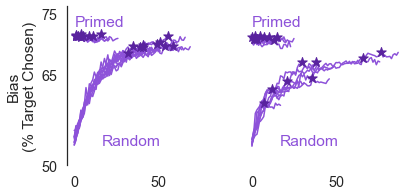

DFCQBR


  0%|          | 0/38 [00:00<?, ?it/s]

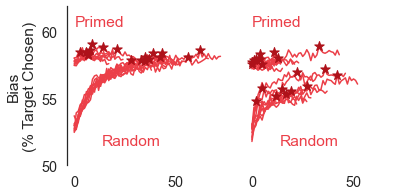

DFOSCQBR


  0%|          | 0/39 [00:00<?, ?it/s]

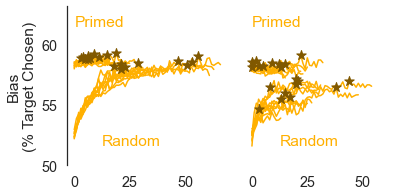

FRBR


  0%|          | 0/40 [00:00<?, ?it/s]

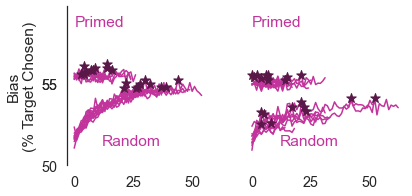

RBR


  0%|          | 0/40 [00:00<?, ?it/s]

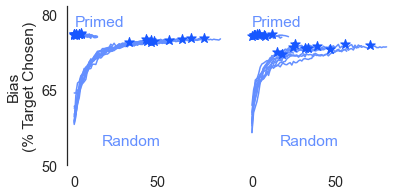

In [100]:
np.random.seed(15403997)
for model in list(filter(lambda v:'.' not in v,os.listdir("Optimal_Schedules/acceptreject"))):
    print(model)
    model_name = model_simple_abv_map[model]
    color = colors[model_name]

    fitness = list(filter(lambda v: "fitnesses" in v,os.listdir(f"Optimal_Schedules/acceptreject/{model}")))
    fitness = [str(f"Optimal_Schedules/acceptreject/{model}/"+x) for x in fitness]

    fitnesses = []
    for fitness_dir in tqdm(fitness):
        with open(fitness_dir, "rb") as f:
            fitness = pickle.load(f)
        fitnesses.append(fitness)
    
    sns.set(style="white",font_scale=1.3)
    fig,ax = plt.subplots(1,2,figsize=(6,3),sharey=True,sharex=True)
    for i in range(len(fitnesses)):
        fit = np.array(fitnesses[i])*100
        if fit.shape[1] == 101:
            ax[1].plot(fit.max(axis=1),color=color)
            # mark the best schedule
            x = np.argmax(fit.max(axis=1))
            y = fit.max(axis=1).max()
            ax[1].scatter(x,y,marker='*',s=100,color=change_lightness(color,1.5),zorder=100)
        else:
            ax[0].plot(fit.max(axis=1),color=color)
            # mark the best schedule
            x = np.argmax(fit.max(axis=1))
            y = fit.max(axis=1).max()
            ax[0].scatter(x,y,marker='*',s=100,color=change_lightness(color,1.5),zorder=100)
    
    # add text "random" and "primed" to the plots
    ax[0].text(0.4,0.15,"Random",transform=ax[0].transAxes,ha='center',va='center',color=color)
    ax[0].text(0.2,0.9,"Primed",transform=ax[0].transAxes,ha='center',va='center',color=color)
    ax[1].text(0.4,0.15,"Random",transform=ax[1].transAxes,ha='center',va='center',color=color)
    ax[1].text(0.2,0.9,"Primed",transform=ax[1].transAxes,ha='center',va='center',color=color)

    ax[0].set_ylim(50,fit.max()*1.07)
    ax[1].set_ylim(50,fit.max()*1.07)
    # round y ticks to nearest 5
    ax[0].set_yticks(np.arange(50,fit.max()*1.07,5)[[0,-1,len(np.arange(50,fit.max()*1.07,5))//2]])
    
    ax[0].set_ylabel('Bias\n(% Target Chosen)')

    # remove all spines except left
    for i in range(2):
        for spine in ax[i].spines.values():
            spine.set_visible(False)
    ax[0].spines['left'].set_visible(True)

    # save figure
    plt.tight_layout()
    plt.savefig(f"figures/optimization_{model_name}.pdf",bbox_inches='tight')

    plt.show()

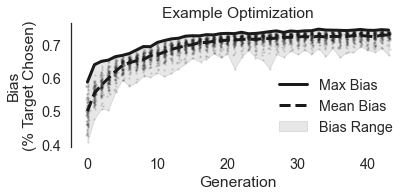

In [105]:
np.random.seed(123456789)
sns.set(style="white",font_scale=1.3)
fig,ax = plt.subplots(1,1,figsize=(6,3))
fit = np.array(fitnesses[np.random.choice(len(fitnesses))])
ax.plot(fit.max(axis=1),color='k',linewidth=3,label='Max Bias')
ax.plot(fit.mean(axis=1),color='k',linewidth=3,linestyle='--',label='Mean Bias')
for i in range(fit.shape[0]):
    ax.scatter(np.ones(fit.shape[1])*i+0.1*np.random.normal(size=fit.shape[1]),fit[i],s=2,color='k',alpha=0.1)
plt.fill_between(np.arange(fit.shape[0]),fit.min(axis=1),fit.max(axis=1),alpha=0.1,color='k',label='Bias Range')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
ax.set_ylabel('Bias\n(% Target Chosen)')
ax.set_xlabel('Generation')
ax.set_title('Example Optimization')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"figures/optimization_example.pdf",bbox_inches='tight')
plt.show()

In [11]:
# search all directories and subdirectories for choice.csv files

# create a list of all directories with choice.csv files
choice_dirs = []
for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith("choice.csv"):
            choice_dirs.append(root)

# ensure each directory also has a mch_reward.csv and oct_reward.csv file, if not remove from list
for choice_dir in choice_dirs:
    if not os.path.isfile(os.path.join(choice_dir, "mch_reward.csv")):
        choice_dirs.remove(choice_dir)
    if not os.path.isfile(os.path.join(choice_dir, "oct_reward.csv")):
        choice_dirs.remove(choice_dir)

In [12]:
# find all directories with FRBR in the name
frbr_dirs = list(filter(lambda x: "FRBR" in x, choice_dirs))

# find all directories with DFOSCQBR in the name
dfoscqbr_dirs = list(filter(lambda x: "DFOSCQBR" in x, choice_dirs))

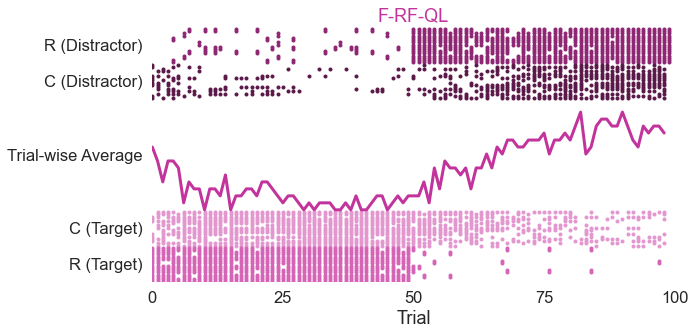

In [13]:
## FOR F-RF-QL

# get experiment name from directory name
frbr_names = list(map(lambda x: int(x.split("_")[-2].split("exp")[1]), frbr_dirs)).copy()

color = colors["F-RF-QL"]

# plot the schedule for each experiment
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

interval = 0.02
n = len(frbr_dirs)

frbr_choices = np.zeros((n, 99))
for i,frbr_dir in enumerate(frbr_dirs):
    # load the choice data
    choice_data = np.loadtxt(os.path.join(frbr_dir, "choice.csv"), delimiter=",")
    # load the reward data
    mch_reward_data = np.loadtxt(os.path.join(frbr_dir, "mch_reward.csv"), delimiter=",")
    oct_reward_data = np.loadtxt(os.path.join(frbr_dir, "oct_reward.csv"), delimiter=",")
    # plot the schedule
    if frbr_names[i]%2 == 0:
        ax.plot(np.where(choice_data == 0)[0],np.zeros(np.where(choice_data == 0)[0].shape) + interval*i + interval*n, ".", color=change_lightness(color, 0.5))
        ax.plot(np.where(choice_data == 1)[0],np.ones(np.where(choice_data == 1)[0].shape) + interval*i + interval*n*2, ".", color=change_lightness(color, 1.5))
        frbr_choices[i,:] = choice_data
        # plot the reward
        ax.plot(np.where(mch_reward_data == 1)[0],np.zeros(np.where(mch_reward_data == 1)[0].shape) + interval*i, ".", color=change_lightness(color, 0.75))
        ax.plot(np.where(oct_reward_data == 1)[0],np.ones(np.where(oct_reward_data == 1)[0].shape) + interval*i + interval*n*2 + interval*n, ".", color=change_lightness(color, 1.25))
    else:
        ax.plot(np.where(choice_data == 0)[0],np.ones(np.where(choice_data == 0)[0].shape) + interval*i + interval*n*2, ".", color=change_lightness(color, 1.5))
        ax.plot(np.where(choice_data == 1)[0],np.zeros(np.where(choice_data == 1)[0].shape) + interval*i + interval*n, ".", color=change_lightness(color, 0.5))
        frbr_choices[i,:] = 1-choice_data
        # plot the reward
        ax.plot(np.where(mch_reward_data == 1)[0],np.ones(np.where(mch_reward_data == 1)[0].shape) + interval*i + interval*n*2 + interval*n, ".", color=change_lightness(color, 1.25))
        ax.plot(np.where(oct_reward_data == 1)[0],np.zeros(np.where(oct_reward_data == 1)[0].shape) + interval*i, ".", color=change_lightness(color, 0.75))
# plot the average choice
ax.plot(np.mean(frbr_choices, axis=0)+interval*n*2, color=color, linewidth=3)
ax.set_xlim(0, 99)
ax.set_ylim(0, 1+interval*n*4)
ax.set_yticks([interval*(n//2), interval*(n//2)*3, (1+interval*n*4)/2, 1+interval*(n//2)+interval*n*2, 1+interval*(n//2)*3+interval*n*2])
ax.set_yticklabels(["R (Target)", "C (Target)", "Trial-wise Average", "C (Distractor)","R (Distractor)"])
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xlabel("Trial")

ax.set_title("F-RF-QL", color=color)

plt.box(False)
plt.tight_layout()
plt.savefig("figures/F-RF-QL_schedule.pdf")
plt.show()


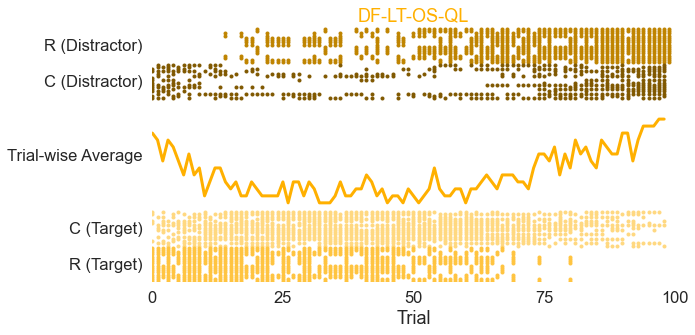

In [14]:
## FOR DF-LT-OS-QL

# get experiment name from directory name
dfoscqbr_names = list(map(lambda x: int(x.split("_")[-2].split("exp")[1]), dfoscqbr_dirs)).copy()

color = colors["DF-LT-OS-QL"]

# plot the schedule for each experiment
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

interval = 0.02
n = len(dfoscqbr_dirs)

dfoscqbr_choices = np.zeros((n, 99))
for i,dfoscqbr_dir in enumerate(dfoscqbr_dirs):
    # load the choice data
    choice_data = np.loadtxt(os.path.join(dfoscqbr_dir, "choice.csv"), delimiter=",")
    # load the reward data
    mch_reward_data = np.loadtxt(os.path.join(dfoscqbr_dir, "mch_reward.csv"), delimiter=",")
    oct_reward_data = np.loadtxt(os.path.join(dfoscqbr_dir, "oct_reward.csv"), delimiter=",")
    # plot the schedule
    if dfoscqbr_names[i]%2 == 0:
        ax.plot(np.where(choice_data == 0)[0],np.zeros(np.where(choice_data == 0)[0].shape) + interval*i + interval*n, ".", color=change_lightness(color, 0.5))
        ax.plot(np.where(choice_data == 1)[0],np.ones(np.where(choice_data == 1)[0].shape) + interval*i + interval*n*2, ".", color=change_lightness(color, 1.5))
        dfoscqbr_choices[i,:] = choice_data
        # plot the reward
        ax.plot(np.where(mch_reward_data == 1)[0],np.zeros(np.where(mch_reward_data == 1)[0].shape) + interval*i, ".", color=change_lightness(color, 0.75))
        ax.plot(np.where(oct_reward_data == 1)[0],np.ones(np.where(oct_reward_data == 1)[0].shape) + interval*i + interval*n*2 + interval*n, ".", color=change_lightness(color, 1.25))
    else:
        ax.plot(np.where(choice_data == 0)[0],np.ones(np.where(choice_data == 0)[0].shape) + interval*i + interval*n*2, ".", color=change_lightness(color, 1.5))
        ax.plot(np.where(choice_data == 1)[0],np.zeros(np.where(choice_data == 1)[0].shape) + interval*i + interval*n, ".", color=change_lightness(color, 0.5))
        dfoscqbr_choices[i,:] = 1-choice_data
        # plot the reward
        ax.plot(np.where(mch_reward_data == 1)[0],np.ones(np.where(mch_reward_data == 1)[0].shape) + interval*i + interval*n*2 + interval*n, ".", color=change_lightness(color, 1.25))
        ax.plot(np.where(oct_reward_data == 1)[0],np.zeros(np.where(oct_reward_data == 1)[0].shape) + interval*i, ".", color=change_lightness(color, 0.75))
# plot the average choice
ax.plot(np.mean(dfoscqbr_choices, axis=0)+interval*n*2, color=color, linewidth=3)
ax.set_xlim(0, 99)
ax.set_ylim(0, 1+interval*n*4)
ax.set_yticks([interval*(n//2), interval*(n//2)*3, (1+interval*n*4)/2, 1+interval*(n//2)+interval*n*2, 1+interval*(n//2)*3+interval*n*2])
ax.set_yticklabels(["R (Target)", "C (Target)", "Trial-wise Average", "C (Distractor)","R (Distractor)"])
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xlabel("Trial")

ax.set_title("DF-LT-OS-QL", color=color)

plt.box(False)
plt.tight_layout()
plt.savefig("figures/DF-LT-OS-QL_schedule.pdf")
plt.show()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

FRBR vs. DFOSCQBR: Mann-Whitney-Wilcoxon test two-sided, P_val:2.994e-01 U_stat=1.000e+02
Effect size:  0.21875


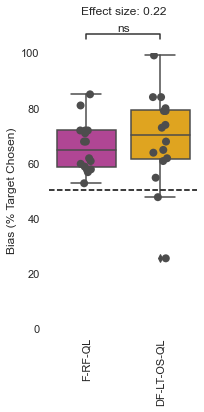

In [21]:
## FOR FRBR
frbr_bias = (1-np.mean(frbr_choices, axis=1) ) * 100 

## FOR DFOSCQBR
dfoscqbr_bias = (1-np.mean(dfoscqbr_choices, axis=1)) * 100

# create a dataframe for the bias
bias_df = pd.DataFrame({"Bias": np.concatenate((frbr_bias, dfoscqbr_bias)), "Biasing Schedule": np.concatenate((["FRBR"]*len(frbr_bias), ["DFOSCQBR"]*len(dfoscqbr_bias)))})

# drop index 12
# bias_df = bias_df.drop(12)

# plot the bias using seaborn
sns.set(style="white", font_scale=1.0)
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
ax = sns.boxplot(x="Biasing Schedule", y="Bias", data=bias_df, ax=ax, palette=[colors["F-RF-QL"], colors["DF-LT-OS-QL"]])
sns.stripplot(x="Biasing Schedule", y="Bias", data=bias_df, jitter=True, color=".3", ax=ax, size=8)
pairs = [("FRBR", "DFOSCQBR")]

# plot the significance 
annotator = Annotator(ax, pairs, data=bias_df, x="Biasing Schedule", y="Bias")
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# calculate the effect size
eff = cliffsDelta(frbr_bias, dfoscqbr_bias)
print("Effect size: ", eff)

# add the effect size to the plot
ax.text(0.5, 1.15, "Effect size: {:.2f}".format(eff), transform=ax.transAxes, ha="center", va="center")

# set the axis labels
ax.set_ylabel("Bias (% Target Chosen)")
ax.set_xlabel("")

# set the axis ticks
ax.set_xticklabels(["F-RF-QL", "DF-LT-OS-QL"], rotation=90)

# dotted line at 50
ax.axhline(50, linestyle="--", color="black")

# set y axis limits
ax.set_ylim(0, 100)

plt.box(False)
plt.tight_layout()
plt.savefig("figures/bias.pdf")
plt.show()

  0%|          | 0/11 [00:00<?, ?it/s]

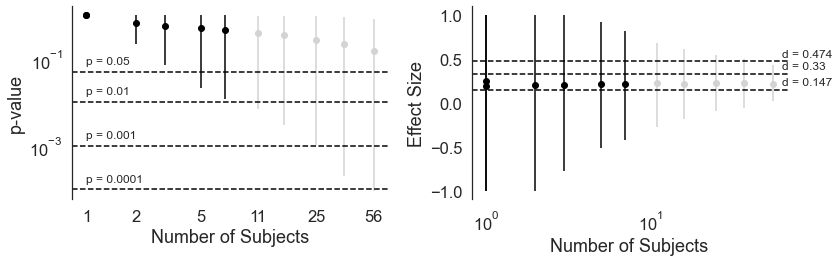

In [16]:
# bias sensitivity analysis
n_boots = 1000
sns.set(style="white", font_scale=1.5)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for n_data in tqdm(list(np.logspace(0, 1.75, 11).astype(int))):
    # sample the data
    frbr_bias_sample = np.random.choice(frbr_bias, size=(n_boots, n_data), replace=True)
    dfoscqbr_bias_sample = np.random.choice(dfoscqbr_bias, size=(n_boots, n_data), replace=True)
    # calculate the p value for each bootstrap
    p_values = np.zeros(n_boots)
    for i in range(n_boots):
        p_values[i] = stats.mannwhitneyu(frbr_bias_sample[i,:], dfoscqbr_bias_sample[i,:])[1]
    # calculate the effect size using cliff's delta
    effs = np.zeros(n_boots)
    for i in range(n_boots):
        effs[i] = cliffsDelta(frbr_bias_sample[i,:], dfoscqbr_bias_sample[i,:])
        #
    # plot the p values
    ax[0].errorbar([n_data], [np.mean(p_values)], yerr=[[np.mean(p_values)-np.percentile(p_values, 2.5)], [np.percentile(p_values, 97.5)-np.mean(p_values)]], fmt="o", color="black" if n_data<10 else "lightgray")
    # plot the effect sizes
    ax[1].errorbar([n_data], [np.mean(effs)], yerr=[[np.mean(effs)-np.percentile(effs, 2.5)], [np.percentile(effs, 97.5)-np.mean(effs)]], fmt="o", color="black" if n_data<10 else "lightgray")
ax[0].axhline(0.05, linestyle="--", color="black")
ax[0].text(1, 1.5*0.05, "p = 0.05", fontsize=12)
ax[0].axhline(0.01, linestyle="--", color="black")
ax[0].text(1, 1.5*0.01, "p = 0.01", fontsize=12)
ax[0].axhline(0.001, linestyle="--", color="black")
ax[0].text(1, 1.5*0.001, "p = 0.001", fontsize=12)
ax[0].axhline(0.0001, linestyle="--", color="black")
ax[0].text(1, 1.5*0.0001, "p = 0.0001", fontsize=12)
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of Subjects")
ax[0].set_ylabel("p-value")
ax[1].axhline(0.147, linestyle="--", color="black")
ax[1].text(10**1.8, 0.147+0.05, "d = 0.147", fontsize=12)
ax[1].axhline(0.33, linestyle="--", color="black")
ax[1].text(10**1.8, 0.33+0.05, "d = 0.33", fontsize=12)
ax[1].axhline(0.474, linestyle="--", color="black")
ax[1].text(10**1.8, 0.474+0.05, "d = 0.474", fontsize=12)
ax[1].set_xscale("log")
ax[1].set_xlabel("Number of Subjects")
ax[1].set_ylabel("Effect Size")
ax[0].set_xticks(np.logspace(0, 1.75, 6).astype(int))
ax[0].set_xticklabels(np.logspace(0, 1.75, 6).astype(int))
# turn off all the spines except the left
for i in range(2):
    for spine in ax[i].spines.values():
        spine.set_visible(False)
    ax[i].spines["left"].set_visible(True)
plt.tight_layout()
plt.savefig("figures/bias_sensitivity.pdf")
plt.show()
    


In [72]:
# np.random.seed(15403997)
# for model in list(filter(lambda v:'.' not in v,os.listdir("Optimal_Schedules/acceptreject"))):
#     print(model)
#     model_name = model_simple_abv_map[model]
#     best_schedules = list(filter(lambda v: "best_schedule" in v,os.listdir(f"Optimal_Schedules/acceptreject/{model}")))
#     best_schedules = [str(f"Optimal_Schedules/acceptreject/{model}/"+x) for x in best_schedules]

#     fitnesses = []
#     fitness_distributions = []
#     n_agents = 1000
#     agentClass = eval(model_database.loc[model_database.SHORTCODE == model, "AgentClass"].values[0])
#     params, policy_params = generate_params_from_fits(agentClass, n_agents)

#     for schedule_dir in tqdm(best_schedules):
#         with open(schedule_dir, "rb") as f:
#             schedule = pickle.load(f)
#         env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
#         action_histories = get_schedule_histories(env, agentClass, n_agents, params, policy_params)
#         fitnesses.append((np.array(action_histories)==0).mean())
#         fitness_distributions.append((np.array(action_histories)==0).mean(axis=1))

#     # Top 3 best schedules
#     top3indices = np.argsort(fitnesses)[-3:][::-1]
#     top3schedules = [best_schedules[i] for i in top3indices]
#     top3fitnesses = [fitnesses[i] for i in top3indices]
#     top3distributions = [fitness_distributions[i] for i in top3indices]

#     naive_priming_schedule = generate_random_schedule_with_blocks(100, [1,0], [0,1])
#     no_preference_schedule = generate_random_schedule_with_blocks(100, [1,0]*50, [1,0]*50)

#     import seaborn as sns
#     sns.set(style="ticks")
#     sns.set(font_scale=1.1)
#     plt.figure(figsize=(10,5))
#     # Plot the top 3 schedules
#     plt.subplot(1,4,1)

#     n_agents = 1000
#     hists = []
#     schedules = []
#     rank = 1
#     for i,j in zip(top3schedules,[0.5,0.7,0.9]):
#         with open(i, "rb") as f:
#             schedule = pickle.load(f)
#         env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
#         histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
#         histories = np.array(histories)
        
#         schedules.append(np.array(schedule))
#         hists.append(histories)
        
#         for n in range(n_agents//10):
#             plt.plot(np.cumsum(histories[n]==0),np.cumsum(histories[n]==1),'-',color=cmap(j),alpha=1,zorder=np.random.randint(0,n_agents),linewidth=0.2)
#         plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=cmap(j-0.05),zorder=n_agents+1,label=f"Rank {rank}")
#         rank += 1

#     env = ymaze_static(n_trials_per_session=len(schedule), schedule=no_preference_schedule)
#     histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
#     histories = np.array(histories)
#     for n in range(n_agents//10):
#         plt.plot(np.cumsum(histories[n]==0),np.cumsum(histories[n]==1),'-',color='gray',alpha=1,zorder=np.random.randint(0,n_agents),linewidth=0.2)
#     plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='gray',zorder=n_agents+1,label=f"Identical Rewards")

#     plt.plot([0,len(schedule)//2],[0,len(schedule)//2],linewidth=2,color='black',linestyle='--')
#     plt.xlabel('Cumulative number\nof OCT choices')
#     plt.ylabel('Cumulative number\nof MCH choices')
#     plt.box(False)
#     plt.legend(loc='upper right',frameon=False)
#     plt.gca().set_aspect('equal')

#     plt.subplot(1,4,2)
#     for i,j in zip(top3distributions,[0.5,0.7,0.9]):
#         plt.hist(i,bins=np.arange(0,1.1,0.05),color=cmap(j),alpha=0.5,density=True,histtype='step',linewidth=4)
#         plt.axvline(i.mean(),linewidth=2,color=cmap(j-0.05),linestyle='--')
#     plt.hist((histories==0).mean(axis=1),bins=np.arange(0,1.1,0.05),color='gray',alpha=0.5,density=True,histtype='step',linewidth=4)
#     plt.axvline((histories==0).mean(),linewidth=2,color='gray',linestyle='--')
#     plt.yticks([])
#     plt.xlabel('Proportion of trials where OCT choice was chosen')
#     plt.box(False)

#     rank = 1
#     for i,h,j,p in zip(schedules,hists,[0.5,0.7,0.9],[2,4,6]):
#         plt.subplot(3,2,p)
#         plt.plot(np.arange(i.shape[0])[i[:,0]==1],np.zeros(np.sum(i[:,0]==1)),'.',color=cmap(j),linewidth=2)
#         plt.plot(np.arange(i.shape[0])[i[:,1]==1],np.ones(np.sum(i[:,1]==1)),'.',color=cmap(j),linewidth=2)
#         plt.plot(h.mean(axis=0),'-',color=cmap(j-0.05),linewidth=2)
#         plt.yticks([0,1],["OCT","MCH"])
#         plt.xlim([0,i.shape[0]])
#         plt.axhline(0.5,linewidth=2,color='black',linestyle='--')
#         plt.title(f"Rank {rank}: {top3fitnesses[rank-1]*100:.2f}% Bias")
#         plt.box(False)
#         if p==6:
#             plt.xlabel('Trial')
#         else:
#             plt.xticks([])
#         rank += 1

#     plt.suptitle('Top schedules for {} {} agents'.format(n_agents,model_name))
#     plt.tight_layout()
#     plt.savefig('figures/top_schedules_'+model_name+'.pdf',bbox_inches='tight')
#     plt.show()